## Introduction

Zebra mussels were first reported in the Great Lakes region circa 1989 and have since spread throughout much of the upper midwest. Understanding vectors and pathways of spread are critical for predicting and preventing the expansion of non-indigenous aquatic species (NAS). Overland transport via recreational watercraft trailered from infested lakes to new locations is the main vector for the spread of zebra and quagga mussels. However, an empirical understanding of how the number of public launches on a waterbody influences the overall risk for introduction for zebra/quagga mussels.  


#### Hypothesis:
If zebra mussel presence is correlated with level of propagule pressure, then the number of boat ramps will impact the likelihood of introduction because overland transport is the main vector of spread for zebra/quagga mussels.

#### Null Hypothesis: 
There is no correlation between the occurence of zebra/quagga and the numbers of public accesses.

#### Prediction:
Logistic regression will indicate a correlation between the occurence of zebra/quagga and the numbers of public accesses.



## Technical Approach

The goal of this script is to test whether the number of public accesses on a waterbody is correlated with the presence of zebra/quagga mussels for MN. To do so, we will create a GIS pipeline using Python that calls to the USGS NAS Database API and uses helper functions to convert the retrieved data into a usable CSV format.  The code then spatially joins occurrence records pulled from the USGS NAS database API. Public accesses will then be joined to the vector layer and counted by lake. This geodataframe is then joined to the occurence records and a column is added for 'Present' where 1 indicates presence of zebra/quagga mussels and 0 indicates absence of zebra mussels. This final dataframe will then be split into testing and training datasets. A logistic regression model will be fit to the training data and model can then be used to predict to the testing dataset.  Accuracy scores can be produced for both training and testing datasets. Seaborn will be used to visualize the relationship between public accesses and the occurence of zebra/quagga mussels. Code to produce a confusion matrix and use the model to predict to a numpy array containing values for ramps between o and 100 is also provided.

A secondary goal of this script is to be flexible such that the user can ask the same question for other NAS and within other states.  Instructions for modifying the code for a different NAS taxa and state are provided within the README.md

## Download MN_lakes_shapefiles and Extract into Data Subdirectory
https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/NHD/State/Shape/NHD_H_Minnesota_State_Shape.zip

In [1]:
#Import required packages
import pandas as pd
import numpy as np
import geopandas as gpd
import json
import requests
from functools import reduce
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
## Helper Functions to convert USGS NAS Records into geodataframe.
def _get_col_rename(df, dftype):
    """Returns a dictionary of columns to rename based on the dataframe and type('csv' or 'api')"""
    
    # Build a dictionary of column renamings for use in pandas rename function
    renamed_columns = {}
    column_names = list(df.columns)
    lower_columns = [name.lower().replace(' ','').replace('_','') for name in column_names]
    for i in range(len(column_names)):
        renamed_columns[column_names[i]] = lower_columns[i]

    if dftype == 'csv':
        # build csv rename dictionary
        renamed_columns['museumcatno'] = 'museumcatnumber'
        renamed_columns['huc8number']  = 'huc8'
    elif dftype == 'api':
        # build api rename dictionary
        renamed_columns['key']              = 'specimennumber'
        renamed_columns['decimallatitude']  = 'latitude'
        renamed_columns['decimallongitude'] = 'longitude'
        renamed_columns['latlongsource']    = 'source'
        renamed_columns['latlongaccuracy']  = 'accuracy'
    else:
        raise ValueError(f"Dataframe type '{dftype}' invalid - Accepted inputs are 'csv' or 'api'")

    return renamed_columns

In [3]:
## Helper Functions to convert USGS NAS Records into geodataframe.
def _manage_cols(df, drop_list=[], name_dict={}):
    """Private method for dropping and renaming columns in a dataframe, as well as creating one standard table from two different forms."""

    for colname in drop_list:
        if colname not in df:
            raise ValueError(f"Can't drop column '{colname}' - '{colname}' does not exist in dataframe")
    for colname in list(name_dict.keys()):
        if colname not in df:
            raise ValueError(f"Can't rename '{colname}' to '{name_dict[colname]}' - '{colname}' does not exist in dataframe")
        if colname in drop_list:
            raise ValueError(f"Can't rename '{colname}' to '{name_dict[colname]}' - '{colname}' in drop_list")

    column_names = np.setdiff1d(list(df.columns), list(name_dict.keys()))
    lower_columns = [name.lower().replace(' ','').replace('_','') for name in column_names]
    for i in range(len(column_names)):
        name_dict[column_names[i]] = lower_columns[i]
    
    df = df.drop(drop_list, axis=1)
    df = df.rename(columns=name_dict)
    
    return df

In [4]:
## Helper Functions to convert USGS NAS Records into geodataframe.
URL_BASE = 'http://nas.er.usgs.gov/api/v2/'


def api_df(species_id, limit, api_key):
    """Returns a pandas dataframe containing records about a species from the NAS database using their API"""
    
    # Check for API key
    if api_key is not None:
        url_request = f"{URL_BASE}/occurrence/search?species_ID={species_id}&api_key={api_key}"
    else:
        url_request = f"{URL_BASE}/occurrence/search?species_ID={species_id}"
    
    # Get dataframe from API request
    request_json = requests.get(url_request, params={'limit':limit}).json()
    api_df = pd.json_normalize(request_json, 'results')
    api_df = _manage_cols(api_df)

    # Add columns that are in a CSV dataframe but not an API dataframe
    api_df['country']      = np.nan
    api_df['drainagename'] = np.nan

    # Rename columns
    renamed_columns = _get_col_rename(api_df, 'api')
    api_df = api_df.rename(columns=renamed_columns)

    # Reorder columns
    cols = list(api_df.columns)
    cols = cols[0:8] + cols[33:34] + cols[8:33] + cols[34:] # country
    cols = cols[0:16] + cols[34:] + cols[16:34] # drainagename
    api_df = api_df[cols]
    
    return api_df

In [5]:
# Run API function to get records
zm = api_df(species_id = 5, limit = 10000, api_key = {"speciesID":5,"itis_tsn":81339,"group":"Mollusks-Bivalves",
"family":"Dreissenidae","genus":"Dreissena","species":"polymorpha","subspecies":"","variety":"",
"authority":"(Pallas, 1771)","common_name":"zebra mussel","native_exotic":"Exotic","Fresh/Marine/Brackish":"Freshwater"})

In [6]:
# Get only columns we want 
my_data = zm[["commonname", "state", "latitude", "longitude", "year", "status", "accuracy"]]

In [7]:
# Filter data 
my_data_fltr = my_data[(my_data['status'] == 'established') & (my_data['accuracy'] == 'Accurate')
& (my_data['state'] == 'Minnesota')]  ## Replace with your state if using your own waterbody shapefile

In [8]:
# Add column for Present and set values for all rows to 1 
my_data_fltr.loc[:,'Present'] = 1

C:\PROGRA~1\QGIS32~2.3\apps\Python39\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\PROGRA~1\QGIS32~2.3\apps\Python39\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [9]:
# Convert csv to GeoDataFrame using lat/long columns to create point geometries
user_data_gdf = gpd.GeoDataFrame(
    my_data_fltr, geometry=gpd.points_from_xy(my_data_fltr.longitude, my_data_fltr.latitude))

In [10]:
# Fix the crs (for some reason we need to set to a random crs and then convert to the crs we want for this to work)
user_data_gdf.set_crs(4326, inplace = True, allow_override=True)
my_data = user_data_gdf.to_crs(3857)

In [11]:
# Check your data
my_data

,commonname,state,latitude,longitude,year,status,accuracy,Present,geometry
23,zebra mussel,Minnesota,46.746272,-92.124095,1989,established,Accurate,1,POINT (-10255207.345 5900757.097)
339,zebra mussel,Minnesota,43.993271,-91.443062,1992,established,Accurate,1,POINT (-10179395.079 5464400.895)
340,zebra mussel,Minnesota,44.098076,-91.707748,1992,established,Accurate,1,POINT (-10208859.855 5480632.215)
345,zebra mussel,Minnesota,44.160145,-91.810341,1992,established,Accurate,1,POINT (-10220280.396 5490258.500)
357,zebra mussel,Minnesota,44.610962,-92.610870,1992,established,Accurate,1,POINT (-10309394.931 5560481.929)
...,...,...,...,...,...,...,...,...,...
8097,zebra mussel,Minnesota,44.702140,-93.473200,2022,established,Accurate,1,POINT (-10405389.027 5574750.782)
8099,zebra mussel,Minnesota,46.451390,-95.552640,2022,established,Accurate,1,POINT (-10636871.229 5852982.217)
8100,zebra mussel,Minnesota,45.203610,-95.034590,2022,established,Accurate,1,POINT (-10579202.167 5653632.872)
8101,zebra mussel,Minnesota,46.646680,-94.230750,2022,established,Accurate,1,POINT (-10489719.107 5884592.741)


In [12]:
## Import waterbody shapefile, Get lakes larger than .5 km squared, change to projected crs and slice to just the lake name and geometry
MN_lakes = gpd.read_file('./data/Shape/NHDWaterbody.shp')
lake_mask = MN_lakes['areasqkm'] > .5
lakes_filtered = MN_lakes.loc[lake_mask].to_crs(3857)
lakes_gpd = lakes_filtered[['gnis_name', 'geometry']]

In [13]:
## Import Public Accesses shapefile, change to projected crs and slice to just the facility name and geometry
access_df = gpd.read_file('./data/MN_accesses.shp')
access_df_crs = access_df.to_crs(3857)
my_accesses = access_df_crs[['FAC_NAME', 'geometry']]

In [14]:
#Spatial join Points to polygons/ Need to do by nearest because boat ramps might not intersect lake polygon
#Use left join because we want to keep all the accesses and join them to the corresponding lake.
accesses_with_lakes = gpd.sjoin_nearest(my_accesses, lakes_gpd, 'left', max_distance = 100) 

In [15]:
#Slice to what we need
# Rename the columns so we can group by right index (Lake_ID) Using the waterbody original index to groupby 
#ensures we aren't combining the count for ramps from lakes with same name.
accesses_with_lakes_df = pd.DataFrame(accesses_with_lakes[['FAC_NAME', 'index_right']]).rename(columns = {'FAC_NAME' : "ramps", 'index_right' : "lake_ID"})

In [16]:
# Groupby lake ID and count ramps per lake
ramps = pd.DataFrame(accesses_with_lakes_df.groupby(['lake_ID']).count())

In [17]:
# re-merge the ramps with the polygons 
ramps_df = gpd.GeoDataFrame(ramps.merge(lakes_gpd, left_index=True, right_index=True, how = 'right')).dropna()

In [18]:
# Join zm points to ramps layer
positive_lakes = gpd.sjoin_nearest(my_data, ramps_df, how='left')

In [19]:
positive_lakes2 = positive_lakes.drop_duplicates('gnis_name').rename(columns = {'index_right' : "lake_ID"})

In [20]:
pos_lakes = positive_lakes2[['lake_ID', 'ramps', 'Present']]

In [21]:
#create a list of the Lake IDs from positive lakes
positive_lake_IDs = pos_lakes['lake_ID']

In [22]:
# This is for merging on index to get negative lakes
ramps2 = pd.DataFrame(accesses_with_lakes_df.groupby(['lake_ID'], as_index=False).count())

In [23]:
# get lakes not in positive_lake_IDs list
neg_lakes = ramps2[~ramps2['lake_ID'].isin(positive_lake_IDs)]

In [24]:
# add Present Column with 0's
neg_lakes['Present'] = 0

C:\Users\leifh\AppData\Local\Temp\ipykernel_24432\1725012170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_lakes['Present'] = 0


In [25]:
#Concatenate negative and positive dataframes.
training_data = pd.concat([neg_lakes, pos_lakes])

In [26]:
#SLice to the columns we want and convert to numpy array 
my_model_data = training_data[['ramps', 'Present']].to_numpy()

In [27]:
#Use Scikit Learn function to split model data into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(
my_model_data[:,0].reshape(-1, 1), my_model_data[:,1], test_size=0.33, random_state=42)

In [28]:
#Define Logistic Regression Model Variable
logr = LogisticRegression()

In [29]:
# Fit model to training data
logr.fit(x_train, y_train)

LogisticRegression()

## Results

Regression plot shows a mix with no clear pattern between waterbodies per lake and presence of zebra/quagga mussels.

<AxesSubplot:>

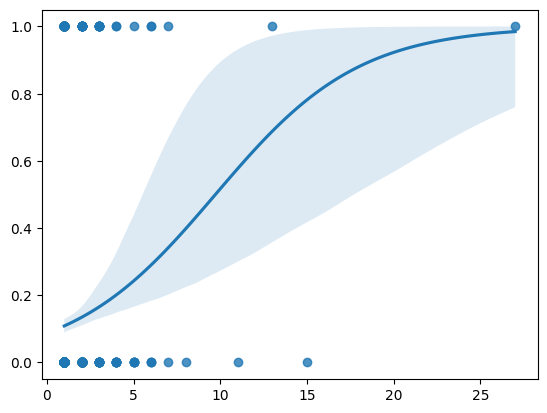

In [30]:
# Visualize regression plot.
sns.regplot(x=x_train, y=y_train, data= training_data, logistic=True)

Testing data is predicted to be all 0's

In [31]:
# Predict to testing dataset
predictions = logr.predict(x_test)
predictions

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

Accuracy looks okay for training/testing data 

In [41]:
# Check accuracy score when predicting to training data
logr.score(x_train,y_train)

0.8810289389067524

In [42]:
# Check Accuracy Score when predicting test data
logr.score(x_test, y_test)

0.8804347826086957

Probability of occurence of zebra/quagga increases by 1.27 for each additional boat ramp

In [43]:
# How does liklihood of invasion increase with an increase in ramps?
log_odds = logr.coef_
odds = np.exp(log_odds)
print(odds)

[[1.27140203]]


Confusion matrix indicates lots of false negatives and predicted only 1 positive

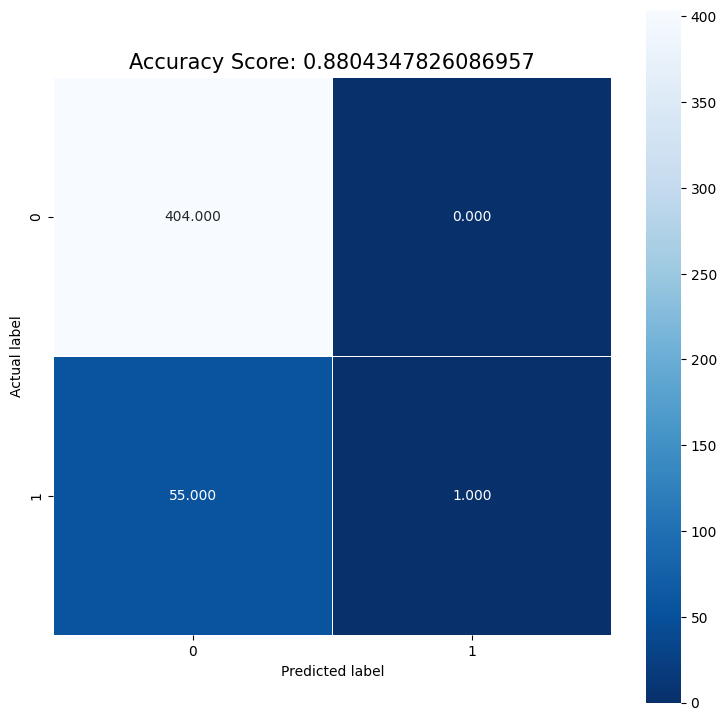

In [45]:
# Create Pretty Confusion Matrix
cm = metrics.confusion_matrix(y_test, predictions)
score = logr.score(x_test, y_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

## Use Model to Predict to Other Data

In [ ]:
# create a random test array
my_test = np.arange(0.0, 100.0 , 1).reshape(-1, 1)

In [ ]:
# Use model to predict test data
logr.predict_proba(my_test)

## Conclusions

Null hypothesis was not falsified.  

Watercraft visits should also be included to better capture use of the accesses within the predictive model.





